In [5]:
import numpy as np
import math
import pandas as pd
import networkx as nx
import random
import collections
import matplotlib.pyplot as plt

# Trabajo final para evaluación de Métodos Numéricos de la Mestría de Ciencia de Datos (equipo 3)
* Jorge García (202945)
* Sandra España (203200)
* Aline Pérez (203096)
* Marco Antonio Ramos (142244)

Este trabajo busca implementar un problema de optimización de distancia recorrida en el metro de la CDMX.

# Creación de la matriz de adyacencias entre las estaciones del metro

Se obtuvo la base de datos de longitud entre estaciones del metro de la CDMX (long_interestacion) y la longitud de la estación (long_estacion). De la misma manera, se creó una lista con todas las estaciones del metro. Los datos originales se pueden consultar en la siguiente [liga](https://metro.cdmx.gob.mx/longitud-de-estacion)

In [7]:
metro1=pd.read_excel('Data1/distancia_metro.xlsx')
np.set_printoptions(precision=2)
nodos1=list(dict.fromkeys(pd.concat([metro1["Estacion1"],metro1["Estacion2"]])))
N=len(nodos1)

Se creó la matriz de adyacencias, en la cual los nodos son las estaciones y los valores son las distancias en metros

In [5]:
df1=np.zeros((N,N))
adyacencia1=pd.DataFrame(df1)
adyacencia1.columns=adyacencia1.index=nodos1

for i in nodos1:
    for j in nodos1:
        adyacencia1[i][j]=metro1[(metro1["Estacion1"]==i)&(metro1["Estacion2"]==j)]["Long_interestacion"]

adyacencia1=adyacencia1.fillna(0)
adyacencia1=np.transpose(adyacencia1)+adyacencia1
print(adyacencia1)

                      Pantitlan  Zaragoza  GomezFarias  BoulevardPuertoAereo  \
Pantitlan                   0.0    1320.0          0.0                   0.0   
Zaragoza                 1320.0       0.0        762.0                   0.0   
GomezFarias                 0.0     762.0          0.0                 611.0   
BoulevardPuertoAereo        0.0       0.0        611.0                   0.0   
Balbuena                    0.0       0.0          0.0                 595.0   
...                         ...       ...          ...                   ...   
MartinCarrera               0.0       0.0          0.0                   0.0   
BarrancadelMuerto           0.0       0.0          0.0                   0.0   
Constitucionde1917          0.0       0.0          0.0                   0.0   
LaPaz                       0.0       0.0          0.0                   0.0   
Buenavista                  0.0       0.0          0.0                   0.0   

                      Balbuena  Moctezu

Verificamos que no haya columnas que no tengan distancias en ninguna de sus entradas

In [149]:
print("máxima distancia por estación\n")
print("\n",np.max(adyacencia1))
print("\nverificamos que no haya un máximo igual a cero (es decir, que todas las estaciones tengan al menos una adyacencia)\n")
print("\n",np.sort(np.max(adyacencia1)))

máxima distancia por estación


 Pantitlan               1644.0
Zaragoza                1320.0
GomezFarias              762.0
BoulevardPuertoAereo     611.0
Balbuena                 703.0
                         ...  
MartinCarrera           1141.0
BarrancadelMuerto       1476.0
Constitucionde1917      1137.0
LaPaz                   1956.0
Buenavista               521.0
Length: 164, dtype: float64

verificamos que no haya un máximo igual a cero (es decir, que todas las estaciones tengan al menos una adyacencia)


 [ 445.  456.  516.  521.  564.  574.  587.  602.  611.  611.  611.  620.
  634.  637.  645.  653.  657.  657.  659.  665.  665.  698.  702.  703.
  703.  709.  709.  715.  725.  725.  732.  745.  745.  750.  755.  757.
  761.  762.  774.  788.  789.  793.  793.  794.  817.  817.  843.  860.
  884.  908.  908.  908.  910.  910.  924.  924.  942.  950.  959.  968.
  969.  969.  973.  993.  993. 1033. 1033. 1042. 1059. 1060. 1060. 1062.
 1067. 1072. 1084. 1106. 1110. 1110. 1111

/Users/1thaliaespana1/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/Users/1thaliaespana1/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


# Creación del grafo de la matriz de adyacencias

# Matriz de afluencia

Como complemento al modelo original y queriendo responder preguntas como: ¿Que ruta es más cómoda en términos de afluencia de personas?, es decir que pasa si como usuario del metro me interesa más que la ruta más corta la ruta más cómoda en términos del número de personas que la transitan. 
<br>
<br>
Bajo este enfoque nos interesa agregar la siguiente base tomada de https://datos.cdmx.gob.mx/dataset/afluencia-diaria-del-metro-cdmx , Esta base muestra la afluencia diaria del Metro CDMX. Los datos se encuentran actualizados al 1 de diciembre de 2022 y su profundidad histórica abarca desde enero 2010 al 31 de octubre 2022. 
<br>
<br>
La base de afluencia desglosada se refiere a la afluencia en el Organismo Público de Transporte STC Metro, separada por medio de acceso, los cuales son: Tarjeta Única de Movilidad Integrada, boleto y gratuidad, esta última se refiere al acceso gratuito para las personas adultos mayores, personas con discapacidad y/o niños menores de 5 años, de acuerdo a los requisitos establecidos por el Organismo.


In [12]:
afluencia = pd.read_csv('Data1/afluenciastc_simple_01_12_2022.csv', encoding='cp1252')
afluencia['fecha']=pd.to_datetime(afluencia['fecha'], format='%d/%m/%Y')
afluencia.head()

,fecha,anio,mes,linea,estacion,afluencia
0,2010-01-01,2010,Enero,Linea 1,Zaragoza,20227
1,2010-01-01,2010,Enero,Linea 1,Isabel la CatÃ³lica,6487
2,2010-01-01,2010,Enero,Linea 1,Moctezuma,10304
3,2010-01-01,2010,Enero,Linea 1,Pino SuÃ¡rez,8679
4,2010-01-01,2010,Enero,Linea 1,GÃ³mez FarÃ­as,19499


Por ejemplo podemos ver el top 5 de las estaciones con mayor afluencia para el día más reciente en la base '2022-10-31', sin considerar la linea:

In [41]:
afluencia[afluencia['fecha']=='2022-10-31'].groupby(['fecha','estacion'])['afluencia'].sum().sort_values(ascending=False)\
.head(5)

fecha       estacion             
2022-10-31  PantitlÃ¡n               159357
            Indios Verdes            102621
            ConstituciÃ³n de 1917     87075
            Tacubaya                  81492
            TasqueÃ±a                 73599
Name: afluencia, dtype: int64

In [46]:
afluencia[(afluencia['fecha']=='2022-10-31')&(afluencia['estacion'].str.contains('Pantitl'))]

,fecha,anio,mes,linea,estacion,afluencia
913978,2022-10-31,2022,Octubre,Linea 1,PantitlÃ¡n,0
914069,2022-10-31,2022,Octubre,Linea 5,PantitlÃ¡n,51160
914124,2022-10-31,2022,Octubre,Linea 9,PantitlÃ¡n,61233
914135,2022-10-31,2022,Octubre,Linea A,PantitlÃ¡n,46964


In [51]:
afluencia.groupby(['fecha','estacion'])['afluencia'].sum().sort_values(ascending=False)

fecha       estacion             
2012-12-07  PantitlÃ¡n               460089
2014-09-09  PantitlÃ¡n               448771
2018-10-26  PantitlÃ¡n               448747
2018-11-27  PantitlÃ¡n               447495
2018-11-30  PantitlÃ¡n               446905
                                      ...  
2021-07-10  Mexicaltzingo                 0
2010-09-18  Parque de los Venados         0
2012-02-22  20 de Noviembre               0
2010-09-18  Olivos                        0
2010-01-01  20 de Noviembre               0
Name: afluencia, Length: 764033, dtype: int64

<AxesSubplot:xlabel='fecha'>

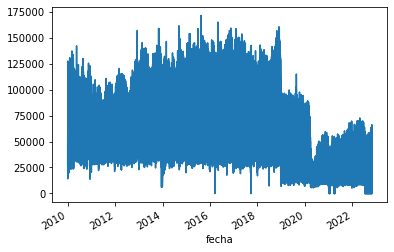

In [48]:
afluencia2 = afluencia.set_index('fecha')
afluencia2[afluencia2['estacion'].str.contains('Pantitl')]['afluencia'].plot()

Observemos que Pantitlán por ejemplo es una de las estaciones que históricamente ha tenido mayor afluencia de personas, también podemos notar que antes de la pandemia, la concentración de personas era mucho mayor, que post-Covid. Esto nos lleva a preguntarnos como integrar esta información en nuestros datos dado que históricamente cada estación tiene una afluencia distinta. Lo más sencillo es cortar nuestra información a partir de 2021 donde la movilidad empieza a estabilizarse debido a que la pandemia comienza su desaceleración, de esta manera podemos tomarnos como valor fijo entre nodos la mediana de los datos, para este rango de fechas, siendo este un mejor estimador que la media.
<br>
<br>
Supondremos además que la afluencia tiene dirección, es decir si vas en la línea 1 por ejemplo de Zaragoza a Pantitlán, sabemos que la mediana de afluencia en Pantitlán es n, así que en esa dirección habrá n cantidad de personas aproximadamente, y viceversa. 
<br>
<br>
Este quizá sea uno de los supuestos más grandes al integrar esta matriz al modelo, pues no estamos considerando horarios, la afluencia es el número de personas totales al día, sin considerar que en horarios 6-9 am o 6-9 pm, son horarios de mucho mayor cocentración de personas por las horas laborales entre semana y varian bastante los fines de semana.
